In [18]:
import os

def update_bags(line):
    bag_of_word = dict()
    split = line.split(" ")
    for word_count in split[1:]:
        word, count_str = word_count.split(":")
        count = int(count_str)
        bag_of_word[word] = count
    label = int(split[0])
    bool_label = 1 if label == 1 else 0
    return bag_of_word, bool_label

def open_file(filepath):    
    bags_of_words = []
    class_labels = []
    with open(filepath) as fp:
        for line in fp:
            bag_of_words, bool_label = update_bags(line)
            bags_of_words.append(bag_of_words)
            class_labels.append(bool_label)
    return bags_of_words, class_labels

def create_data_table(bags, class_labels):
    data_table = list()
    for i in range(len(bags) + 1):
        row = list()
        data_table.append(row)
    
    for i in range(len(bags)):
        for word in bags[i]:
            if word in data_table[0]:
                data_table[i+1][data_table[0].index(word)] += bags[i][word]
            else:
                data_table[0].append(word)
                for j in range(len(bags)):
                    data_table[j+1].append(0)
                data_table[i+1][-1] += bags[i][word]
    for i in range(len(bags)):
        data_table[i+1].append(class_labels[i])
    return data_table

def create_dataset(file_name, training_size, testing_size):
    bags_of_words, class_labels = open_file(file_name)
    data_table = create_data_table(bags_of_words, class_labels)
    training_data_table = data_table[0] + data_table[1:training_size+1]
    if testing_size != 0:
        testing_data_table = data_table[0] + data_table[training_size+1:]
    else:
        testing_data_table = []
    return training_data_table, testing_data_table
    

In [2]:
def cal_model(file_name, training_size, testing_size):
    training_data_table, testing_data_table = create_dataset(file_name, training_size, testing_size)
    y1_count = 0
    y0_count = 0
    for i in range(len(training_data_table)-1):
        if training_data_table[i + 1][-1] == 1:
            y1_count += 1
        else:
            y0_count += 1
    y1_prob = y1_count/(len(training_data_table)-1)
    y0_prob = y0_count/(len(training_data_table)-1)

    prior_knowledge = dict()
    vocabulary = len(training_data_table[0])
    word_num_y1 = 0
    word_num_y0 = 0
    for i in range(len(training_data_table)-1):
        if training_data_table[i+1][-1] == 1:
            word_num_y1 += sum(training_data_table[i+1])-1
        else:
            print(training_data_table[i+1])
            word_num_y0 += sum(training_data_table[i+1])


    for i in range(len(training_data_table[0])):
        x1_count = 0
        x0_count = 0
        for j in range(len(training_data_table)-1):
            if training_data_table[j+1][-1] == 1:
                x1_count += training_data_table[j+1][i]
            else:
                x0_count += training_data_table[j+1][i]
        prob_x = [(x1_count+1)/(word_num_y1+vocabulary), (x0_count+1)/(word_num_y0+vocabulary)]
        prior_knowledge[training_data_table[0][i]] = prob_x
    return y1_prob, y0_prob, prior_knowledge, training_data_table, testing_data_table

In [3]:
def NB_relevant_NB_retraining_v3():
    # pre-trained model
    y1_prob, y0_prob, prior_knowledge, training_data_table, testing_data_table = cal_model('task_a_labeled_train.tf', 1000, 0)
    print('Pre-model is built')
    
    # the current small model
    y1_prob_transfer, y0_prob_transfer, prior_knowledge_transfer, training_data_table_transfer, testing_data_table_transfer = cal_model('task_a_labeled_tune.tf', 1000, 500)
    print('Target-model is built')
    
    accuracy_original = cal_direct_accuracy(testing_data_table_transfer, y1_prob_transfer, y0_prob_transfer, prior_knowledge_transfer)
    print('accuracy(no_transfer): ', accuracy_original)
    
    accuracy_transfer = cal_direct_accuracy(testing_data_table_transfer, y1_prob_transfer, y0_prob_transfer, prior_knowledge)
    print('accuracy(directly_transfer): ', accuracy_transfer)
    
    print('Retraining start...')
    for word in prior_knowledge.keys():
        if word in prior_knowledge_transfer.keys():
            prior_overall_chi2 = 0
            [probX_Y1, probX_Y0] = prior_knowledge[word]
            [probX_Y1_transfer, probX_Y0_transfer] = prior_knowledge_transfer[word]
            positive_chi2, negative_chi2 = cal_chi2(probX_Y1, probX_Y0, probX_Y1_transfer, probX_Y0_transfer)
            positive_learning_rate = 0.05 if positive_chi2 > negative_chi2 else 0.01
            negative_learning_rate = 0.05 if positive_chi2 < negative_chi2 else 0.01
            overall_chi2 = max([positive_chi2, negative_chi2])
            while abs(prior_overall_chi2 - overall_chi2) >= 0.0000001: 
                probX_Y1 += (probX_Y1_transfer - probX_Y1) * positive_learning_rate
                probX_Y0 += (probX_Y0_transfer - probX_Y0) * negative_learning_rate
                prior_knowledge[word] = [probX_Y1, probX_Y0]
                positive_chi2, negative_chi2 = cal_chi2(probX_Y1, probX_Y0, probX_Y1_transfer, probX_Y0_transfer)
                prior_overall_chi2 = overall_chi2
                overall_chi2 = max([positive_chi2, negative_chi2])
        else:
            [probX_Y1, probX_Y0] = prior_knowledge[word]
            prior_knowledge[word] = [probX_Y1 * 0.9, probX_Y0 * 0.9]
    print('Retraining end...')
    
    # merge new words of current model into pre-model
    for word in prior_knowledge_transfer.keys():
        if word not in prior_knowledge.keys():
            prior_knowledge[word] = prior_knowledge_transfer[word]
    
    accuracy_relevant_transfer = cal_direct_accuracy(testing_data_table_transfer, y1_prob_transfer, y0_prob_transfer, prior_knowledge)
    print('accuracy_relevant_transfer: ', accuracy_relevant_transfer)
    return accuracy_original, accuracy_transfer, accuracy_relevant_transfer

In [4]:
NB_relevant_NB_retraining_v3()

94


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [1]:
from NB_Relevance_amazon import NB_relevant_NB_retraining_v3_progress

error_rate_list = NB_relevant_NB_retraining_v3_progress(10000, 0, 5000, 10000)

Pre-model is built
Target-model is built
Retraining start...
0.1331
0.12209999999999999
0.11929999999999996
0.11950000000000005


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(0, len(error_rate_list)*2000, 2000), error_rate_list, label='toy to garden')

plt.title('Error Rate in Amazon Reviews dataset')
plt.xlabel('Fine tuning words')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

In [1]:
from NB_Relevance_amazon import NB_relevant_NB_retraining_v3
NB_relevant_NB_retraining_v3('Toys_and_Games.json.gz', 5000, 0, 'Patio_Lawn_and_Garden.json.gz', 1000, 2000)

Pre-model is built
Target-model is built
4962
9987
accuracy(no_transfer):  0.288
accuracy(directly_transfer):  0.815
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.8345


(0.288, 0.815, 0.8345)

In [1]:
from NB_Relevance_amazon import NB_relevant_NB_retraining_v3
NB_relevant_NB_retraining_v3('Toys_and_Games.json.gz', 5000, 0, 'Patio_Lawn_and_Garden.json.gz', 1000, 2000)

Pre-model is built
Target-model is built
4962
9987
accuracy(no_transfer):  0.288
accuracy(directly_transfer):  0.815
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.6655


(0.288, 0.815, 0.6655)

In [2]:
from NB_Relevance_amazon import NB_relevant_NB_retraining_v3
NB_relevant_NB_retraining_v3('Toys_and_Games.json.gz', 5000, 0, 'Patio_Lawn_and_Garden.json.gz', 5000, 2000)

Pre-model is built
Target-model is built
6106
11399
accuracy(no_transfer):  0.713
accuracy(directly_transfer):  0.9355
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.9385


(0.713, 0.9355, 0.9385)

In [3]:
from NB_Relevance_amazon import NB_relevant_NB_retraining_v3
NB_relevant_NB_retraining_v3('Toys_and_Games.json.gz', 10000, 0, 'Patio_Lawn_and_Garden.json.gz', 5000, 2000)

Pre-model is built
Target-model is built
7090
12979
accuracy(no_transfer):  0.713
accuracy(directly_transfer):  0.962
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.964


(0.713, 0.962, 0.964)

In [1]:
from NB_Relevance_amazon import NB_relevant_NB_retraining_v3

no_transfer = [0] * 5
transfered = [0] * 5
no_transfer[0], acc, transfered[0] = NB_relevant_NB_retraining_v3('Toys_and_Games.json.gz', 10000, 0, 'Patio_Lawn_and_Garden.json.gz', 5000, 5000)
no_transfer[1], acc, transfered[1] = NB_relevant_NB_retraining_v3('Video_Games.json.gz', 10000, 0, 'Toys_and_Games.json.gz', 5000, 5000)
no_transfer[2], acc, transfered[2] = NB_relevant_NB_retraining_v3('Cell_Phones_and_Accessories.json.gz', 10000, 0, 'Electronics.json.gz', 5000, 5000)
no_transfer[3], acc, transfered[3] = NB_relevant_NB_retraining_v3('Electronics.json.gz', 10000, 0, 'Toys_and_Games.json.gz', 5000, 5000)
no_transfer[4], acc, transfered[4] = NB_relevant_NB_retraining_v3('Patio_Lawn_and_Garden.json.gz', 10000, 0, 'Electronics.json.gz', 5000, 5000)

Pre-model is built
Target-model is built
6559
12532
accuracy(no_transfer):  0.769
accuracy(directly_transfer):  0.6876
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.6658
Pre-model is built
Target-model is built
8159
18769
accuracy(no_transfer):  0.9192
accuracy(directly_transfer):  0.8804
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.8942
Pre-model is built
Target-model is built
7946
14735
accuracy(no_transfer):  0.737
accuracy(directly_transfer):  0.8678
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.8416
Pre-model is built
Target-model is built
7687
15149
accuracy(no_transfer):  0.9192
accuracy(directly_transfer):  0.8546
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.8548
Pre-model is built
Target-model is built
7062
13840
accuracy(no_transfer):  0.737
accuracy(directly_transfer):  0.8288
Retraining start...
Retraining end...
accuracy_relevant_transfer:  0.8104


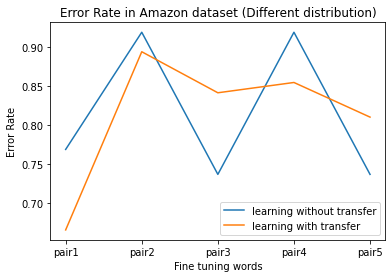

In [2]:
from matplotlib import pyplot as plt
x_axis = ['pair1', 'pair2', 'pair3', 'pair4', 'pair5']
plt.plot(x_axis, no_transfer, label='learning without transfer')
plt.plot(x_axis, transfered, label='learning with transfer')

plt.title('Error Rate in Amazon dataset (Different distribution)')
plt.xlabel('Fine tuning words')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

In [1]:
from NB_Relevance_spam import NB_relevant_NB_retraining_v3_progress
error_rate_list = NB_relevant_NB_retraining_v3_progress('task_a_labeled_train.tf', 4000, 0, 'task_a_labeled_tune.tf', 1000, 1500)

Pre-model is built
Target-model is built
Retraining start...
0.04733333333333334
0.043333333333333335
0.04800000000000004
0.050000000000000044
0.050000000000000044
0.05266666666666664
0.05666666666666664
0.062000000000000055
0.06266666666666665
0.06066666666666665
0.06066666666666665
0.06000000000000005
0.06399999999999995
0.06799999999999995
0.07266666666666666
0.06333333333333335
0.06333333333333335
0.06466666666666665
0.06599999999999995
0.058666666666666645
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
0.055333333333333345
Retraining end...


In [2]:
error_rate_list

[0.44733333333333336,
 0.048666666666666636,
 0.04733333333333334,
 0.043333333333333335,
 0.04800000000000004,
 0.050000000000000044,
 0.050000000000000044,
 0.05266666666666664,
 0.05666666666666664,
 0.062000000000000055,
 0.06266666666666665,
 0.06066666666666665,
 0.06066666666666665,
 0.06000000000000005,
 0.06399999999999995,
 0.06799999999999995,
 0.07266666666666666,
 0.06333333333333335,
 0.06333333333333335,
 0.06466666666666665,
 0.06599999999999995,
 0.058666666666666645,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345,
 0.055333333333333345]